## Download

In [3]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 43.8 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for python-crfsuite>=0.8.3 from https://files.pythonhosted.org/packages/38/1d/c475ba7d11e9735f00eb08e2f5315aa2e21c24cc85a0474c3fd425edef58/python_crfsuite-0.9.10-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.1 MB/s eta 0:00:00


## Import libraries

In [4]:
import re
import ast
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from torch.optim import Adam
from torchtext.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pyvi import ViTokenizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# pre-processing

In [5]:
def normalize(text):
    t = text.replace('\n', ' ')
    t = t.lower()
    return t

def delete_hashtag(text):
    return re.sub(r'#\w+', '', text)

def delete_link(text):
    return re.sub(r'http\S+', '', text)

def remove_emojis(text):
    emoj = re.compile(r"""[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF\U00002702-\U000027B0\U000024C2-\U0001F251\U0001f926-\U0001f937\U00010000-\U0010ffff\u200d\u23cf\u23e9\u231a\ufe0f\u3030-]+(?<!\n)""", re.UNICODE)
    return re.sub(emoj, '', text)

def encode_number(text):
    t = text.split(' ')
    t = map(lambda x: '<number>' if bool(re.match(r'^[0-9]+(\.[0-9]+)?$', x)) else x, t)
    return ' '.join(t)

def delete_onelen_token(text):
    t = text.split(' ')
    t = filter(lambda x: len(x)>1, t)
    return ' '.join(t)

def preprocessing(text):
    t = normalize(text)
    t = delete_hashtag(t)
    t = delete_link(t)
    t = remove_emojis(t)
    t = ViTokenizer.tokenize(t)
    t = encode_number(t)
    t = delete_onelen_token(t)
    return t

#Model and Training

## Define class dataset

In [6]:
class HashTag_Dataset(Dataset):
  def __init__(self, root, max_length=250):
    super(HashTag_Dataset, self).__init__()
    self.classes = ['#Q&A', '#cv', '#data', '#deep_learning', '#machine_learning', '#math', '#nlp', '#python', '#sharing']
    text, labels = [], []

    df = pd.read_csv(root, encoding='utf-8-sig')
    texts = df['text']
    labels = df["label"]
    self.texts = texts
    self.labels = labels
    self.vocab = self.make_vocab(texts)
    self.max_length = max_length
  def make_vocab(self, texts):
    vocab = dict()
    for text in texts:
      words = text.split()
      for word in words:
        if word not in vocab:
          vocab[word] = 1
        else:
          vocab[word] += 1
    vocab = list(dict(filter(lambda x: x[1]>3, vocab.items())).keys())
    vocab.append('<UNK>')
    vocab.append('<PAD>')
    return vocab
  def encode_text(self, text):
    words = text.split()
    if len(words) > self.max_length:
      words = words[:self.max_length]
    else:
      words += ['<PAD>']*(self.max_length-len(words))
    enc = [self.vocab.index(w) if w in self.vocab else self.vocab.index('<UNK>') for w in words]
    return enc
  def encode_label(self, label):
    enc = ast.literal_eval(label)
    enc = [1 if l in enc else 0 for l in self.classes]
    return enc
  def __len__(self):
    return len(self.labels)

  def len_vocab(self):
    return len(self.vocab)

  def num_classes(self):
    return len(self.classes)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]
    encode = self.encode_text(text)
    label = self.encode_label(label)
    encode = torch.tensor(encode, dtype=torch.long)
    label = torch.tensor(label, dtype=torch.float32)
    return encode, label

## Create the model

In [7]:
class HashtagRecommendation(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, num_labels):
    super(HashtagRecommendation, self).__init__()
    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
    self.fc1 = nn.Linear(hidden_dim, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, num_labels)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, sentence):
    embeds = self.word_embeddings(sentence)
    lstm_out, _ = self.lstm(embeds)
    # Select the last output of LSTM layer
    lstm_out = lstm_out[:, -1, :]
    x = self.relu(self.fc1(lstm_out))
    x = self.dropout(x)
    x = self.relu(self.fc2(x))
    x = self.dropout(x)
    logits = self.fc3(x)
    probs = self.sigmoid(logits)
    return probs

# define metrics

In [15]:
nINF = -100
class TwoWayLoss(nn.Module):
    def __init__(self, Tp=4., Tn=1.):
        super(TwoWayLoss, self).__init__()
        self.Tp = Tp
        self.Tn = Tn

    def forward(self, x, y):
        class_mask = (y > 0).any(dim=0)
        sample_mask = (y > 0).any(dim=1)

        # Calculate hard positive/negative logits
        pmask = y.masked_fill(y <= 0, nINF).masked_fill(y > 0, float(0.0))
        plogit_class = torch.logsumexp(-x/self.Tp + pmask, dim=0).mul(self.Tp)[class_mask]
        plogit_sample = torch.logsumexp(-x/self.Tp + pmask, dim=1).mul(self.Tp)[sample_mask]
    
        nmask = y.masked_fill(y != 0, nINF).masked_fill(y == 0, float(0.0))
        nlogit_class = torch.logsumexp(x/self.Tn + nmask, dim=0).mul(self.Tn)[class_mask]
        nlogit_sample = torch.logsumexp(x/self.Tn + nmask, dim=1).mul(self.Tn)[sample_mask]

        return torch.nn.functional.softplus(nlogit_class + plogit_class).mean() + \
                torch.nn.functional.softplus(nlogit_sample + plogit_sample).mean()
def get_criterion(args):
    if args.loss == 'TwoWayLoss':
        return TwoWayLoss(Tp=args.loss_Tp, Tn=args.loss_Tn)
    else:
        raise ValueError(f"Not supported loss {args.loss}")

In [10]:
def accuracy(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
      temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
  return temp / y_true.shape[0]
def Recall(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
      if sum(y_true[i]) == 0:
          continue
      temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
  return temp/ y_true.shape[0]
def Precision(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
      if sum(y_pred[i]) == 0:
          continue
      temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_pred[i])
  return temp/ y_true.shape[0]
def F1Measure(y_true, y_pred):
  temp = 0
  for i in range(y_true.shape[0]):
      if (sum(y_true[i]) == 0) and (sum(y_pred[i]) == 0):
          continue
      temp+= (2*sum(np.logical_and(y_true[i], y_pred[i])))/ (sum(y_true[i])+sum(y_pred[i]))
  return temp/ y_true.shape[0]

# Training

In [12]:
train_set = HashTag_Dataset(root = "/kaggle/input/cs11444/train_data.csv")
test_set = HashTag_Dataset(root = "/kaggle/input/cs11444/test_data.csv")
test_loader = DataLoader(test_set, batch_size=8)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
num_epochs = 300

In [13]:
model = HashtagRecommendation(embedding_dim=100,hidden_dim=256,num_labels=train_set.num_classes(), vocab_size=train_set.len_vocab())
model = model.to(device)
criterion = TwoWayLoss()
optimizer = Adam(model.parameters(), lr=0.0001)
num_iters = len(train_loader)

In [16]:
best_acc = 0
trainingEpoch_loss = []
for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(train_loader, colour='green')
    step_loss = []

    for iter, (texts, labels) in enumerate(progress_bar):
        texts = texts.to(device)
        labels = labels.to(dtype=torch.float).to(device)

        # forward
        outputs = model(texts)
        loss_value = criterion(outputs, labels)  # Find the loss

        # backward
        optimizer.zero_grad() # clear the gradients
        loss_value.backward() # calculate gradients
        optimizer.step() # update weights

        # Calculate loss
        progress_bar.set_description("Epoch {}/{}. Iteration {}/{}. Loss {:.5f}".format(epoch+1, num_epochs, iter+1, num_iters, loss_value.item()))
        step_loss.append(loss_value.item())
    trainingEpoch_loss.append(np.array(step_loss).mean())

    # evaluate
    model.eval()
    y_true = []
    y_pred = []

    test_progress_bar = tqdm(test_loader, colour='green')
    with torch.no_grad():
        for iter, (texts, labels) in enumerate(test_progress_bar):
            texts = texts.to(device)
            labels = labels.to(dtype=torch.float).to(device)
            outputs = np.array(model(texts).tolist())
            y_pred.extend((outputs >= 0.5).astype(np.float32))
            y_true.extend(labels.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    acc = accuracy(y_true, y_pred)

    print(f"Accuracy: {acc}")

    if acc > best_acc:
        best_acc = acc
        print(f"Saving model at epoch {epoch}")
        torch.save(model, f'/kaggle/working//best_model_epoch_{epoch}.pth')

100%|██████████| 30/30 [00:01<00:00, 25.70it/s]


Accuracy: 0.30956450956450965
Saving model at epoch 0


100%|██████████| 30/30 [00:01<00:00, 24.59it/s]


Accuracy: 0.34764957264957314
Saving model at epoch 1


100%|██████████| 30/30 [00:01<00:00, 25.78it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 23.94it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.42it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 24.36it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.66it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 24.72it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.41it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.41it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.63it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.56it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.40it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.51it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.02it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.41it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.46it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.16it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 24.40it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.07it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.08it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.72it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.56it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.56it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 23.99it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.60it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.44it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.59it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.64it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.13it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.51it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.62it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.57it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 24.85it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.23it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.78it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.68it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.52it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.53it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 24.85it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.41it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.69it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.69it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.70it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.12it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.57it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.69it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.57it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.58it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 24.38it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 24.62it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 24.69it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 21.51it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 24.43it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.39it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.16it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 23.43it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.55it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.49it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.65it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.58it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.63it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.60it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.51it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.54it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.41it/s]


Accuracy: 0.33012820512820507


100%|██████████| 30/30 [00:01<00:00, 25.48it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.56it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.40it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.55it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 24.56it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.44it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.72it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.49it/s]


Accuracy: 0.3324074074074073


100%|██████████| 30/30 [00:01<00:00, 25.70it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.66it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.43it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.31it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.51it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.75it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.68it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.68it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.10it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.73it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.85it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.71it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.79it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.29it/s]


Accuracy: 0.332051282051282


100%|██████████| 30/30 [00:01<00:00, 25.20it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 24.88it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 24.92it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 21.05it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 24.17it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 24.25it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.07it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 24.25it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.41it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.21it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.58it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.40it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.49it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.47it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.54it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.61it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.69it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.31it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.03it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.63it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.73it/s]


Accuracy: 0.3292022792022792


100%|██████████| 30/30 [00:01<00:00, 25.65it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.71it/s]


Accuracy: 0.3306267806267805


100%|██████████| 30/30 [00:01<00:00, 23.54it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.77it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.63it/s]


Accuracy: 0.32955840455840446


100%|██████████| 30/30 [00:01<00:00, 25.72it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 23.80it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 24.87it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.47it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.58it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.64it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.70it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.55it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.56it/s]


Accuracy: 0.3295584045584045


100%|██████████| 30/30 [00:01<00:00, 25.60it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.59it/s]


Accuracy: 0.3306267806267805


100%|██████████| 30/30 [00:01<00:00, 25.69it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.07it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.30it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.48it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 23.47it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.77it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 24.22it/s]


Accuracy: 0.32991452991452985


100%|██████████| 30/30 [00:01<00:00, 25.10it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.59it/s]


Accuracy: 0.3309829059829059


100%|██████████| 30/30 [00:01<00:00, 25.72it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.48it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.65it/s]


Accuracy: 0.32991452991452985


100%|██████████| 30/30 [00:01<00:00, 25.59it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 24.28it/s]


Accuracy: 0.32955840455840446


100%|██████████| 30/30 [00:01<00:00, 25.55it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.21it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 24.40it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.53it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.68it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.75it/s]


Accuracy: 0.3324074074074073


100%|██████████| 30/30 [00:01<00:00, 25.80it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.66it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.66it/s]


Accuracy: 0.32813390313390306


100%|██████████| 30/30 [00:01<00:00, 25.37it/s]


Accuracy: 0.32955840455840446


100%|██████████| 30/30 [00:01<00:00, 25.19it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.47it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 24.76it/s]


Accuracy: 0.3324074074074073


100%|██████████| 30/30 [00:01<00:00, 25.44it/s]


Accuracy: 0.3324074074074073


100%|██████████| 30/30 [00:01<00:00, 25.29it/s]


Accuracy: 0.3308404558404558


100%|██████████| 30/30 [00:01<00:00, 25.47it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.46it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.13it/s]


Accuracy: 0.3324074074074073


100%|██████████| 30/30 [00:01<00:00, 25.59it/s]


Accuracy: 0.33133903133903125


100%|██████████| 30/30 [00:01<00:00, 25.34it/s]


Accuracy: 0.32834757834757833


100%|██████████| 30/30 [00:01<00:00, 25.22it/s]


Accuracy: 0.3322649572649572


100%|██████████| 30/30 [00:01<00:00, 25.43it/s]


Accuracy: 0.3324074074074073


100%|██████████| 30/30 [00:01<00:00, 25.18it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.42it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 24.92it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.43it/s]


Accuracy: 0.3306267806267805


100%|██████████| 30/30 [00:01<00:00, 25.32it/s]


Accuracy: 0.32955840455840446


100%|██████████| 30/30 [00:01<00:00, 25.34it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.71it/s]


Accuracy: 0.3295584045584045


100%|██████████| 30/30 [00:01<00:00, 25.30it/s]


Accuracy: 0.32834757834757833


100%|██████████| 30/30 [00:01<00:00, 25.49it/s]


Accuracy: 0.32834757834757833


100%|██████████| 30/30 [00:01<00:00, 24.02it/s]


Accuracy: 0.3269230769230769


100%|██████████| 30/30 [00:01<00:00, 25.45it/s]


Accuracy: 0.32991452991452985


100%|██████████| 30/30 [00:01<00:00, 24.17it/s]


Accuracy: 0.33012820512820507


100%|██████████| 30/30 [00:01<00:00, 25.47it/s]


Accuracy: 0.3295584045584045


100%|██████████| 30/30 [00:01<00:00, 24.71it/s]


Accuracy: 0.3295584045584045


100%|██████████| 30/30 [00:01<00:00, 25.47it/s]


Accuracy: 0.3295584045584045


100%|██████████| 30/30 [00:01<00:00, 25.41it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.40it/s]


Accuracy: 0.32991452991452985


100%|██████████| 30/30 [00:01<00:00, 25.23it/s]


Accuracy: 0.33012820512820507


100%|██████████| 30/30 [00:01<00:00, 24.98it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.27it/s]


Accuracy: 0.32991452991452985


100%|██████████| 30/30 [00:01<00:00, 25.33it/s]


Accuracy: 0.3295584045584045


100%|██████████| 30/30 [00:01<00:00, 25.41it/s]


Accuracy: 0.33119658119658113


100%|██████████| 30/30 [00:01<00:00, 25.35it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 24.92it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 24.58it/s]


Accuracy: 0.32834757834757833


100%|██████████| 30/30 [00:01<00:00, 24.70it/s]


Accuracy: 0.3306267806267805


100%|██████████| 30/30 [00:01<00:00, 24.47it/s]


Accuracy: 0.3324074074074073


100%|██████████| 30/30 [00:01<00:00, 24.25it/s]


Accuracy: 0.3294159544159544


100%|██████████| 30/30 [00:01<00:00, 25.46it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 24.80it/s]


Accuracy: 0.32834757834757833


100%|██████████| 30/30 [00:01<00:00, 25.69it/s]


Accuracy: 0.32834757834757833


100%|██████████| 30/30 [00:01<00:00, 25.63it/s]


Accuracy: 0.32834757834757833


100%|██████████| 30/30 [00:01<00:00, 25.56it/s]


Accuracy: 0.3308404558404558


100%|██████████| 30/30 [00:01<00:00, 25.31it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.53it/s]


Accuracy: 0.33012820512820507


100%|██████████| 30/30 [00:01<00:00, 25.40it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.67it/s]


Accuracy: 0.3295584045584045


100%|██████████| 30/30 [00:01<00:00, 25.47it/s]


Accuracy: 0.33012820512820507


100%|██████████| 30/30 [00:01<00:00, 24.66it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.31it/s]


Accuracy: 0.33012820512820507


100%|██████████| 30/30 [00:01<00:00, 25.44it/s]


Accuracy: 0.33098290598290586


100%|██████████| 30/30 [00:01<00:00, 25.54it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.47it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.58it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.22it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.39it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.25it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.64it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 24.92it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 24.85it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 23.21it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.40it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.08it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.40it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.41it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.70it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.70it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.47it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.33it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.60it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 25.04it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 25.52it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 25.05it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.59it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 24.89it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.16it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 24.90it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.05it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 24.84it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.18it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.03it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.05it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 24.25it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 23.53it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 25.37it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.51it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 25.27it/s]


Accuracy: 0.32977207977207973


100%|██████████| 30/30 [00:01<00:00, 25.03it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 25.51it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.55it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.61it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.36it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 24.71it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.63it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.35it/s]


Accuracy: 0.32849002849002845


100%|██████████| 30/30 [00:01<00:00, 25.56it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.45it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 24.42it/s]


Accuracy: 0.32849002849002845


100%|██████████| 30/30 [00:01<00:00, 25.56it/s]


Accuracy: 0.32849002849002845


100%|██████████| 30/30 [00:01<00:00, 24.26it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.62it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 25.42it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.59it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 25.78it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.72it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.46it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 24.24it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 24.57it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.38it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 24.61it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 24.47it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 24.93it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.07it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 24.85it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 25.64it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.41it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 25.60it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 25.47it/s]


Accuracy: 0.32834757834757833


100%|██████████| 30/30 [00:01<00:00, 24.81it/s]


Accuracy: 0.32834757834757833


100%|██████████| 30/30 [00:01<00:00, 25.43it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 25.36it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.58it/s]


Accuracy: 0.32834757834757833


100%|██████████| 30/30 [00:01<00:00, 25.33it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.16it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.56it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 25.52it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.10it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 23.81it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.42it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 24.74it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.36it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 24.66it/s]


Accuracy: 0.32870370370370366


100%|██████████| 30/30 [00:01<00:00, 24.41it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 24.32it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 24.99it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 25.46it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 24.80it/s]


Accuracy: 0.32585470085470086


100%|██████████| 30/30 [00:01<00:00, 25.07it/s]


Accuracy: 0.326923076923077


100%|██████████| 30/30 [00:01<00:00, 25.29it/s]


Accuracy: 0.3265669515669516


100%|██████████| 30/30 [00:01<00:00, 25.53it/s]


Accuracy: 0.327991452991453


100%|██████████| 30/30 [00:01<00:00, 25.19it/s]


Accuracy: 0.32727920227920226


100%|██████████| 30/30 [00:01<00:00, 25.45it/s]

Accuracy: 0.32727920227920226


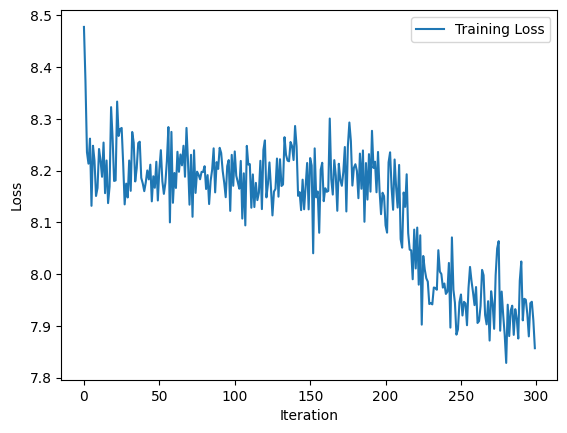

In [17]:
# Plot the loss history
plt.plot(trainingEpoch_loss, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working//training_loss_plot.png')
plt.show()

## Evaluate on test set

In [18]:
model = torch.load('/kaggle/working/best_model_epoch_1.pth')
model.eval()
y_true = []
y_pred = []
progress_bar = tqdm(test_loader, colour='yellow')
with torch.no_grad():
    for iter, (texts, labels) in enumerate(progress_bar):
        texts = texts.to(device)
        labels = labels.to(dtype=torch.float).to(device)
        outputs = np.array(model(texts).tolist())
        y_pred.extend((outputs >= 0.5).astype(np.float32))
        y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
acc = accuracy(y_true, y_pred)
precision = Precision(y_true, y_pred)
recall = Recall(y_true, y_pred)
F1_score = F1Measure(y_true, y_pred)

# Define the table format
table_format = "{:<12} {:<10}"

# Print the title
print("Evaluate on test set")

# Print the table header
print(table_format.format("Metric", "Value"))
print("-" * 22)  # Separating line

# Print rows with metrics
print(table_format.format("Accuracy:", f"{acc:.2%}"))
print(table_format.format("Precision:", f"{precision:.2%}"))
print(table_format.format("Recall:", f"{recall:.2%}"))
print(table_format.format("F1 Score:", f"{F1_score:.2%}"))

100%|██████████| 30/30 [00:01<00:00, 24.85it/s]

Evaluate on test set
Metric       Value     
----------------------
Accuracy:    34.76%    
Precision:   42.59%    
Recall:      62.75%    
F1 Score:    49.48%    


#Testing

In [19]:
#load model
model = torch.load('/kaggle/working/best_model_epoch_1.pth')
print(model)

HashtagRecommendation(
  (word_embeddings): Embedding(2180, 100)
  (lstm): LSTM(100, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=9, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [20]:
sentence = input()

 Mình có tài liệu machine learning muốn chia sẻ


In [23]:
test = preprocessing(sentence)
test = train_set.encode_text(sentence)
test = ToTensor()(test)[None, :]
test = test.to(device)
pred = model(test)[0].tolist()
pred = [train_set.classes[i] for i in range(len(pred)) if pred[i]>0.5]
print("Predict label: ", *pred)

Predict label:  #Q&A #machine_learning #sharing
